# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
/datasets/geo_data_0.csv. 
/datasets/geo_data_1.csv. 
/datasets/geo_data_2.csv. 
id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).

## Ход работы

В ходе работы будут проанализированы 3 датасета, при необходимости произведется очистка данных. Для анализа прибыли будут обучены модели, определяющие запасы нефти в каждом регионе, так же будут оценены риски для каждого региона. После проделанной работы будет предложен регион для разработки.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from numpy.random import RandomState

state = RandomState(12345)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

Напишем функцию для вывода на экран основной информации по датасетам:

In [3]:
def inform(data):
    print(data.info(),
         '\n\n Первые 5 строк датасета: \n', data.head(),   
         '\n\n Разброс данных по столбцам: \n', data.describe(),  
         '\n\n Наличие пропусков: \n', data.isna().sum(),
         '\n\n Корреляция данных: \n', data.corr(),
         '\n\n Ящик с усами f0: \n', sns.boxplot(data=data['f0']),
          plt.show(),
          '\n\n Ящик с усами f1: \n', sns.boxplot(data=data['f1']),
          plt.show(),
          '\n\n Ящик с усами f2: \n', sns.boxplot(data=data['f2']),
          plt.show(),
          '\n\n Ящик с усами product: \n', sns.boxplot(data=data['product']),
          plt.show(),
         '\n\n Гистограмма распределения объёма запасов в скважине (тыс. баррелей): \n', data['product'].hist(bins = 300, figsize=[9,5]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


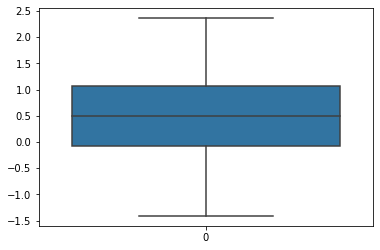

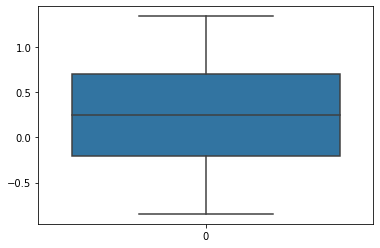

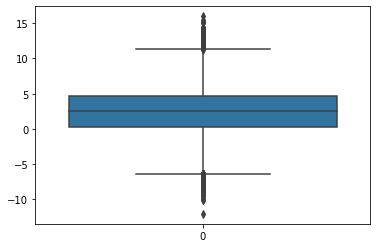

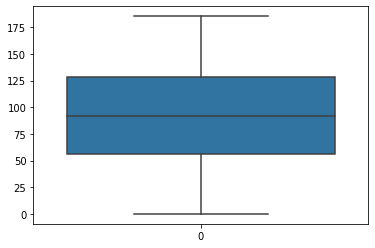

None 

 Первые 5 строк датасета: 
       id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

 Разброс данных по столбцам: 
                   f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347 

 Наличие пропусков: 
 id      

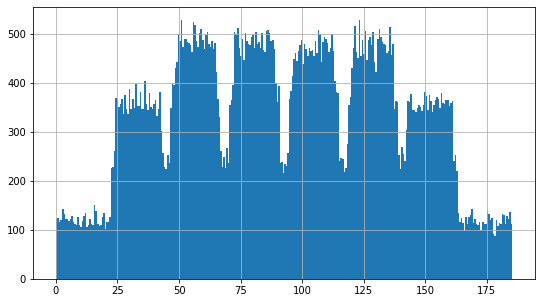

In [4]:
inform(data0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


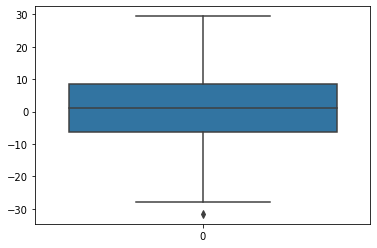

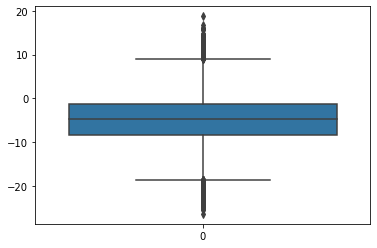

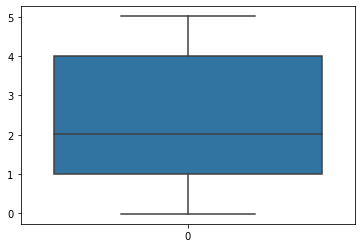

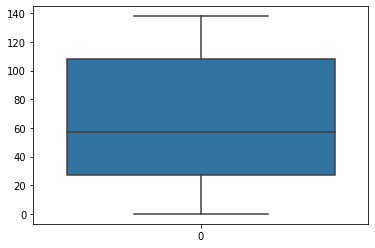

None 

 Первые 5 строк датасета: 
       id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305 

 Разброс данных по столбцам: 
                   f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408 

 Наличие пропусков

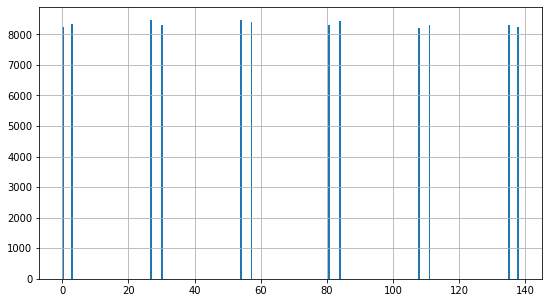

In [5]:
inform(data1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


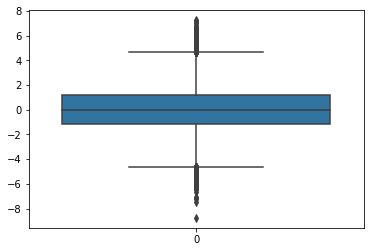

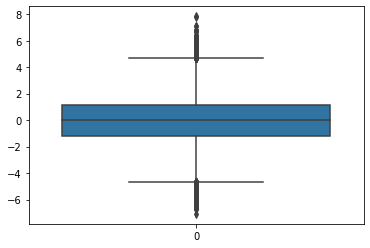

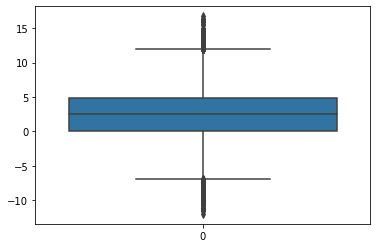

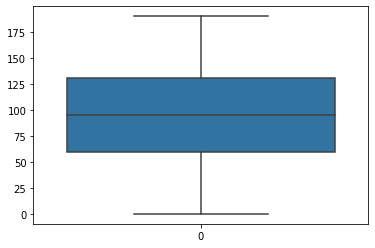

None 

 Первые 5 строк датасета: 
       id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746 

 Разброс данных по столбцам: 
                   f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838 

 Наличие пропусков: 
 id      

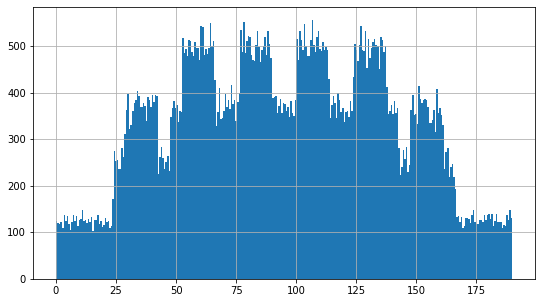

In [6]:
inform(data2)

Во всех датасетах по 10000 строк, пропусков нет, названия колонок одинаковые. 
В некоторых столбцах есть так назывыемые "выбросы", их необходимо удалить, что бы они не мешали модели обучаться.

#### Удаление строк с выбросами:

In [7]:
def cleaning(data, column):
    Q1 =  data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    data[column] = data[(data[column] > Q1-1.5*IQR ) & (data[column] < Q3+1.5*IQR)][column]
    data = data.dropna().reset_index(drop=True)
    return data 

In [8]:
#data0 = cleaning(data0, 'f2')

In [9]:
#data1 = cleaning(data1, 'f0')
#data1 = cleaning(data1, 'f1')

In [10]:
#data2 = cleaning(data2, 'f0')
#data2 = cleaning(data2, 'f1')
#data2 = cleaning(data2, 'f2')

Итак, все датасеты очищены от выбросов, потеря данных не превышает 2%, можно начинать обучать модель.

<div class="alert alert-block alert-info">
<b> 
Закомментила, но не стала удалять. Но как тогда понять, что стоит удалять, а что оставить?
</div>



<div class="alert alert-success">
<h2> Комментарий ревьюера v2 ✔️ <a class="tocSkip"> </h2>

Здесь у нас распределение красивое и не имеет каких-то артефактов. Вот ниже пример с некоторым выбросом, который хорошо бы убрать
    
![](https://i.ibb.co/FhJ9PRP/image.png)

#### Проверка дубликатов

In [11]:
data0['id'].duplicated().sum()

10

In [12]:
data1['id'].duplicated().sum()

4

In [13]:
data2['id'].duplicated().sum()

4

#### Удаление дубликатов

In [14]:
data0['id'].drop_duplicates()

0        txEyH
1        2acmU
2        409Wp
3        iJLyR
4        Xdl7t
         ...  
99995    DLsed
99996    QKivN
99997    3rnvd
99998    7kl59
99999    1CWhH
Name: id, Length: 99990, dtype: object

In [15]:
data1['id'].drop_duplicates()

0        kBEdx
1        62mP7
2        vyE1P
3        KcrkZ
4        AHL4O
         ...  
99995    QywKC
99996    ptvty
99997    09gWa
99998    rqwUm
99999    relB0
Name: id, Length: 99996, dtype: object

In [16]:
data2['id'].drop_duplicates()

0        fwXo0
1        WJtFt
2        ovLUW
3        q6cA6
4        WPMUX
         ...  
99995    4GxBu
99996    YKFjq
99997    tKPY3
99998    nmxp2
99999    V9kWn
Name: id, Length: 99996, dtype: object

#### Промежуточные выводы

Распределение целевого признака в датасетах по регионам 0 и 2 выглядят нормальными, в 1 датасете целевой признак выглядит синтетическим.

В процесе предобработки датасеты были очищены от выбросов для того, что бы лучшим образом реализовать машинное обучение.

## Обучение и проверка модели

### Разделим данные на обучающую и валидационную выборку.

#### Датасет 0:

In [17]:
features0 = data0.drop(['id', 'product'], axis=1)
target0 = data0['product']

In [18]:
features_train0, features_valid0, target_train0, target_valid0 = train_test_split(
    features0, target0, test_size=0.25, random_state=12345
)

In [19]:
features_train0.shape, features_valid0.shape, target_train0.shape, target_valid0.shape

((75000, 3), (25000, 3), (75000,), (25000,))

#### Датасет 1:

In [20]:
features1 = data1.drop(['id', 'product'], axis=1)
target1 = data1['product']

In [21]:
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
    features1, target1, test_size=0.25, random_state=12345
)

In [22]:
features_train1.shape, features_valid1.shape, target_train1.shape, target_valid1.shape

((75000, 3), (25000, 3), (75000,), (25000,))

#### Датасет 2:

In [23]:
features2 = data2.drop(['id', 'product'], axis=1)
target2 = data2['product']

In [24]:
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
    features2, target2, test_size=0.25, random_state=12345
)

In [25]:
features_train2.shape, features_valid2.shape, target_train2.shape, target_valid2.shape

((75000, 3), (25000, 3), (75000,), (25000,))

### Линейная регрессия

In [26]:
model = LinearRegression()

#### Датасет 0:

In [27]:
model.fit(features_train0, target_train0)
predictions_valid0 = model.predict(features_valid0) 
print('Средний запас нефти предсказанный:', predictions_valid0.mean())
print('Средний запас нефти реальный:', data0['product'].mean())
print('RMSE модели', mean_squared_error(target_valid0, predictions_valid0)**0.5)

Средний запас нефти предсказанный: 92.59256778438035
Средний запас нефти реальный: 92.50000000000001
RMSE модели 37.5794217150813


#### Датасет 1:

In [28]:
model.fit(features_train1, target_train1)
predictions_valid1 = model.predict(features_valid1)   
print('Средний запас нефти предсказанный:', predictions_valid1.mean())
print('Средний запас нефти реальный:', data1['product'].mean())
print('RMSE модели', mean_squared_error(target_valid1, predictions_valid1)**0.5)

Средний запас нефти предсказанный: 68.728546895446
Средний запас нефти реальный: 68.82500000000002
RMSE модели 0.893099286775617


#### Датасет 2:

In [29]:
model.fit(features_train2, target_train2)
predictions_valid2 = model.predict(features_valid2)   
print('Средний запас нефти предсказанный:', predictions_valid2.mean())
print('Средний запас нефти реальный:', data2['product'].mean())
print('RMSE модели', mean_squared_error(target_valid2, predictions_valid2)**0.5)

Средний запас нефти предсказанный: 94.96504596800489
Средний запас нефти реальный: 95.00000000000004
RMSE модели 40.02970873393434


#### Выводы

Для определения целевого признака были обучены 3 модели. Было выявлено, что средний запас нефти выше всего во 2 регионе, на втором месте регион 0, в регионе 1 средние запасы нефти ниже всего.

## Подготовка к расчёту прибыли

Сохраним все известные параметры:

In [30]:
BUDGET = 10**10                 #Бюджет на разработку скважин в регионе
BARREL_INCOME = 450             #Доход за баррель
UNIT_INCOME = 450000            #Доход за единице продукции (1 тыс баррелей)
EXPLORED_POINTS = 500           #Количество точек исследования
CHOSEN_POINTS = 200             #Количество лучших точек
MAX_PROBABILITY_OF_LOSS = 0.025 #Максимальная вероятность убытков по условиям

Бюджет на разработку скважин в регионе — 10 млрд рублей. С помощью машинного обучения выбирают 200 лучших точек для разработки. 1 единица продукции в каждой точке стоит 450000 рублей. Таким образом, для того, что бы предприятие не несло убытки, минимальное количество добытых нефтепродуктов должно составлять: 

In [31]:
min_amount = round(BUDGET / (CHOSEN_POINTS * UNIT_INCOME),2)
min_amount

111.11

Таким образом, для работы не в убыток, предприятие должно добывать в точке в среднем, 111.(1) тысячу единиц продукции, а для работы с получением дохода, нефтедобыча в среднем должна превышать рассчитанное значение min_amount.

Средний запас нефти в регионе 0 составляет 92,5, в регоне 1 - 68,8, в регионе 2 - 95,0. Все значения средних запасов по регионам ниже среднего минимального значения, необходимого для добычи без убытков.
Сравнение средней величины запасов нефти со средним минимальным значением количества добываемой нефти, достаточным для безубыточной торговли, не информативно. Тк это разные понятия, основанные на разных закономерностях. Как минимум, потому, что нефтедобыча ведется в 200 лучших точках, а среднее значение запасов рассчитывается по всему региону. Для получения информативных значений, нужно понимать, что количество точек, в которых запасы больше необходимого, достаточно.

Найдем количество скважин в каждом регионе, запасы нефти в которых превышают min_amount:

In [32]:
data0['id'][data0['product'] > min_amount].count() / data0['product'].count()

0.36584

In [33]:
data1['id'][data1['product'] > min_amount].count() / data1['product'].count()

0.16537

In [34]:
data2['id'][data2['product'] > min_amount].count() / data2['product'].count()

0.38178

#### Вывод:

Среднее количество добытой нефти из 1 точки должно составлять не менее 111.(1) тыс тонн.
Количество точек во всех регионах достаточно для получения прибыли. Причем, их количество ниже в регионе 1 и выше всего в регионе 2.

## Расчёт прибыли и рисков 

Прибыль-это проданная нефть из 200 скважин за вычетом расходов на разработку скважин. Для увеличения прибыли, выбирать будем 200 лучших скважин в каждом регионе с помощью предсказаний, а прибыль будем считать на основании истинных значений.

Функция для расчета истинной прибыли для 200 лучших предсказанных скважин:

In [39]:
def profit(target_valid, predictions_valid):
    sort_predictions_valid_series = pd.Series(predictions_valid).sort_values(ascending=False)[:CHOSEN_POINTS]
    target_valid_sort = (target_valid.reset_index(drop = True)[sort_predictions_valid_series.index])
    target_valid_sort_sum = target_valid_sort.sum() 
    print('Истинная прибыль при разработке 200 лучших предсказанных скважин района (млрд. руб.):')

    return round(((target_valid_sort_sum * UNIT_INCOME) - BUDGET) / 10**9,2)

#### Район0:

In [40]:
profit(target_valid0, predictions_valid0)

Истинная прибыль при разработке 200 лучших предсказанных скважин района (млрд. руб.):


3.32

#### Район1:

In [41]:
profit(target_valid1, predictions_valid1)

Истинная прибыль при разработке 200 лучших предсказанных скважин района (млрд. руб.):


2.42

#### Район2:

In [42]:
profit(target_valid2, predictions_valid2)

Истинная прибыль при разработке 200 лучших предсказанных скважин района (млрд. руб.):


2.71

#### Промежуточный вывод:

Самая высокая прибыль возможна при освоении региона 0.

### Рассчет рисков обытков в регионах

Рассчитаем вероятность убытков в регионах. По условиям задачи нам необходимо оставить те, вероятность убытков в которых менее 2,5%.

In [54]:
def revenue(target, probabilities):
    probs_sorted = probabilities.sort_values(ascending=False) #[:explored_points]
    selected = target[probs_sorted.index][:CHOSEN_POINTS]
    selected_sum = selected.sum()
    return (selected_sum * UNIT_INCOME - BUDGET)


def risk_assessment(target_valid, predictions_valid):
    target = pd.Series(target_valid)
    probabilities = pd.Series(predictions_valid, index=target.index)
    
    lost = 0
    values = []
    
    for i in range(1000):
        target_subsample = target.sample(n=EXPLORED_POINTS, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index] 
        subsample = revenue(target_subsample, probs_subsample)
        values.append(subsample)
        if subsample < 0:
            lost += 1
        

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    values_mean = values.mean()
    risk = lost / 1000
    print('Риск убытков (%):', risk, 
          '\n Среднее значение прибыли (млрд):', values_mean / 10**9, 
          '\n 95% доверительный интервал для прибыли', lower, upper, 
          '\n Количество рисков получить убытки (из 1000)', lost)

In [55]:
risk_assessment(target_valid0, predictions_valid0)

Риск убытков (%): 0.06 
 Среднее значение прибыли (млрд): 0.42561036554131826 
 95% доверительный интервал для прибыли -118245549.41941264 952966123.6860889 
 Количество рисков получить убытки (из 1000) 60


In [56]:
risk_assessment(target_valid1, predictions_valid1)

Риск убытков (%): 0.007 
 Среднее значение прибыли (млрд): 0.502842394253506 
 95% доверительный интервал для прибыли 90944836.16367513 894397185.9125582 
 Количество рисков получить убытки (из 1000) 7


In [57]:
risk_assessment(target_valid2, predictions_valid2)

Риск убытков (%): 0.068 
 Среднее значение прибыли (млрд): 0.4198264794790639 
 95% доверительный интервал для прибыли -124444555.57288493 973655281.1533407 
 Количество рисков получить убытки (из 1000) 68


### Выводы:

В ходе проделанной работы были проанализированы 3 датасета с информацией о геологоразведке трёх регионов. Была проделана работа по очистке датасетов от выбросов и обучены модели, предсказывающие запасы нефти в точках. 
Так же были написаны функции по предсказанию прибыли в регионе и для оценки рисков убытков.

Было выявлено, при выборе регионов на основании результатов машинного обучения, риски убытков выше 2,5% для 0 или 2 регионов и ниже 2,5% для первого региона. Такое низкое значение может быть связано с искусственностью данных по этому региону, за счет чего модель хорошо обучается и дает низкую ошибку. Самый высокий риск убытков - в регионе 2 (6,8%).

Предполагаемая прибыль выше всего в регионе 1, а ниже всего-в регионе 2.

*По результатам проведенной работы, для разработки месторождений предлагается регион №1.*